In [1]:
!pip install gpytorch

In [71]:
import numpy as np
import seaborn as sns
import warnings
import copy
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import torch
import gpytorch
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style("darkgrid")
import matplotlib

#matplotlib.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 15

## 学習用コード

In [72]:
# 配列の正規化
def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

# 人工データ生成
class DataGenerator(object):
    def __init__(self, random_seed, sample_size_all, x_low, x_up, err_loc, err_var, object_func):
        self.random_seed=random_seed
        self.sample_size_all=sample_size_all 
        self.x_low=x_low
        self.x_up=x_up
        self.err_loc=err_loc
        self.err_var=err_var
        self.object_func=object_func

    def generate_data(self):
        np.random.seed(self.random_seed)
        x_out = np.linspace(self.x_low, self.x_up, self.sample_size_all).reshape(-1, 1)
        f_out = f(x_out) 
        err = np.random.normal(loc=self.err_loc, scale=self.err_var, size=self.sample_size_all).reshape(-1, 1)
        y_out = f_out + err

        return x_out, y_out, f_out

# ガウス過程モデルの定義
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, 
                 lengthscale_prior=None, outputscale_prior=None):
        super(GPModel, self).__init__(train_x,
                                      train_y,
                                      likelihood,
                                      )
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(
        #    gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        #    outputscale_prior=outputscale_prior
        #    )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# カーネルのハイパーパラメータチューニング (勾配法による周辺尤度最大化に基づく)
class Trainer(object):
    
    def __init__(self, gpr, likelihood, optimizer, mll):
        self.gpr = gpr
        self.likelihood = likelihood
        self.optimizer = optimizer
        self.mll = mll

    def update_hyperparameter(self, epochs):
        self.gpr.train()
        self.likelihood.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            output = self.gpr(self.gpr.train_inputs[0])

            loss = - self.mll(output, self.gpr.train_targets)
            loss.backward()
            self.optimizer.step()

            if epoch % (epochs//10) == 0:
                print('Epoch %d/%d - Loss: %.3f ' % (
                    epoch + 1, epochs, loss.item(),
                    ))


## データとモデルの準備

In [73]:
# ブラックボックス関数
def f(x):
    return -(x + x * np.sin(2 * x))

# データの生成
data_generator = DataGenerator(random_seed=0, sample_size_all=200, x_low=0.5, x_up=5.5, err_loc=0.0, err_var=0.5, object_func=f)
x, y, f_true = data_generator.generate_data()

x_current = copy.deepcopy(x)
y_current = copy.deepcopy(y)
f_true_current = copy.deepcopy(f_true)


# 観測済みデータの保存場所
obs_x = []
obs_y = []

# 初期点を指定
q = random.sample(list(range(0, 200, 1)), 2)
for i in range(len(q)):
    obs_x.append(x[q[i]])
    obs_y.append(y[q[i]])

# 既に観測した点は観測しない場合は使用する
#for idx in sorted(q, reverse=True):
#    x_current = np.delete(x_current, idx)
#    y_current = np.delete(y_current, idx)
#    f_true_current = np.delete(f_true_current, idx)

# GPyTorchに入力できるように加工
## GPでは入力は多次元前提なので (num_data, dim) という shape
## 一方で出力は一次元前提なので (num_data) という形式にする
train_X = torch.from_numpy(np.array(obs_x).astype(np.float32)).clone().reshape(len(obs_x), 1)
train_Y = torch.from_numpy(np.array(obs_y).astype(np.float32)).clone().reshape(len(obs_y))


Epoch 1/2000 - Loss: 1.194 
Epoch 201/2000 - Loss: 0.193 
Epoch 401/2000 - Loss: -0.527 
Epoch 601/2000 - Loss: -0.641 
Epoch 801/2000 - Loss: -0.642 
Epoch 1001/2000 - Loss: -0.642 
Epoch 1201/2000 - Loss: -0.642 
Epoch 1401/2000 - Loss: -0.642 
Epoch 1601/2000 - Loss: -0.642 
Epoch 1801/2000 - Loss: -0.642 
Epoch 1/2000 - Loss: 1.157 
Epoch 201/2000 - Loss: 0.395 
Epoch 401/2000 - Loss: 0.190 
Epoch 601/2000 - Loss: 0.189 
Epoch 801/2000 - Loss: 0.189 
Epoch 1001/2000 - Loss: 0.189 
Epoch 1201/2000 - Loss: 0.189 
Epoch 1401/2000 - Loss: 0.189 
Epoch 1601/2000 - Loss: 0.189 
Epoch 1801/2000 - Loss: 0.189 
Epoch 1/2000 - Loss: 7.785 
Epoch 201/2000 - Loss: 3.868 
Epoch 401/2000 - Loss: 3.323 
Epoch 601/2000 - Loss: 3.115 
Epoch 801/2000 - Loss: 3.006 
Epoch 1001/2000 - Loss: 2.939 
Epoch 1201/2000 - Loss: 2.894 
Epoch 1401/2000 - Loss: 2.863 
Epoch 1601/2000 - Loss: 2.840 
Epoch 1801/2000 - Loss: 2.823 
Epoch 1/2000 - Loss: 6.952 
Epoch 201/2000 - Loss: 3.455 
Epoch 401/2000 - Loss: 3.

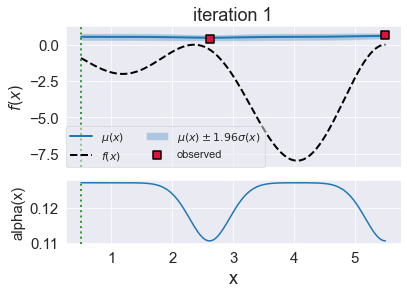

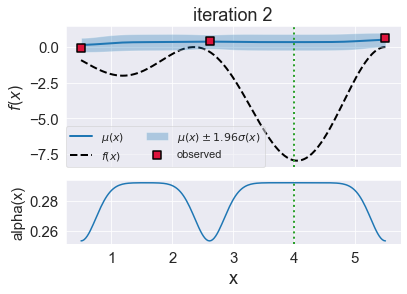

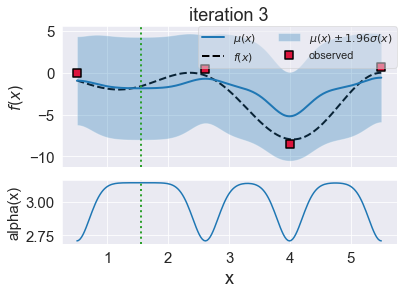

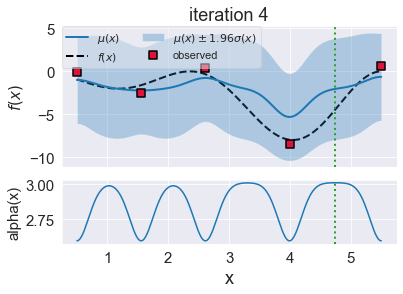

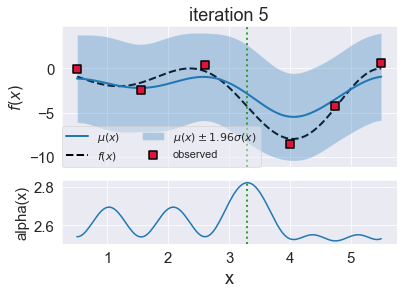

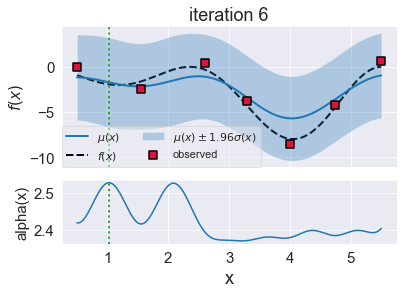

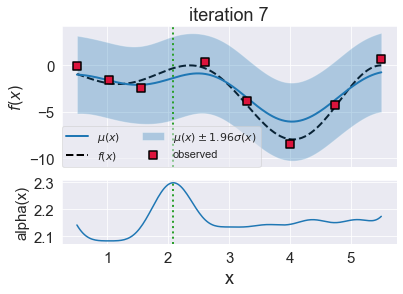

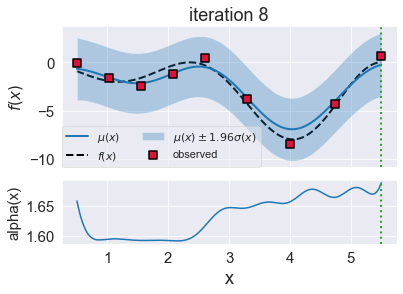

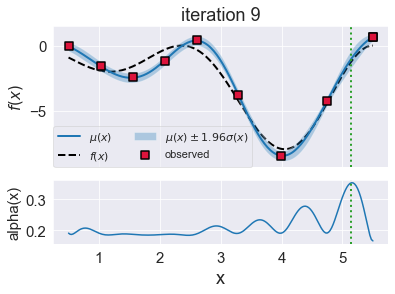

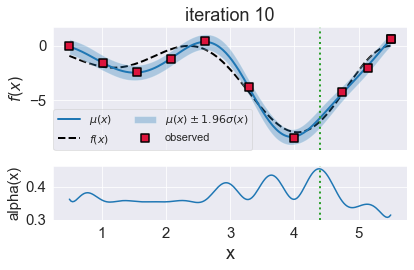

In [74]:
maxitr = 10
pdf = PdfPages("uncertainty_sampling.pdf")
warnings.simplefilter('ignore', FutureWarning)
for itr in range(maxitr):
    # 尤度関数
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # ガウス過程モデルの定義
    gpr = GPModel(train_X, train_Y, likelihood)
    #print(gpr)

    # 定義したガウス過程の対数周辺尤度
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gpr)  

    # ガウス過程のハイパラ調整のためのオプティマイザ
    all_params = set(gpr.parameters())
    optimizer = torch.optim.Adam(all_params, lr=1e-2)    

    # ガウス過程のハイパラ最適化 
    trainer = Trainer(gpr, likelihood, optimizer, mll)
    trainer.update_hyperparameter(2000)

    # 未観測の候補点に対する予測
    test_X = torch.from_numpy(np.array(x_current).astype(np.float32)).clone().reshape(len(x_current), 1)
    test_Y = torch.from_numpy(np.array(y_current).astype(np.float32)).clone().reshape(len(y_current))
    gpr.eval()
    likelihood.eval()
    with torch.no_grad():
        predicts = likelihood(gpr(test_X))
        predicts_mean = predicts.mean
        predicts_std = predicts.stddev
    
    post_mean = predicts_mean.detach().numpy().flatten() # 予測平均
    post_std = predicts_std.detach().numpy().flatten() # 予測分散
    post_ci = 1.96 * post_std # 各点の95%信頼区間

    # プロット (GPモデル)
    fig = plt.figure()
    gs = plt.GridSpec(3, 1)
    ax = [fig.add_subplot(gs[0:2, 0]), fig.add_subplot(gs[2, 0])]
    ax[0].plot(test_X.flatten(), post_mean, label=r"$\mu(x)$", zorder=2, lw=2)
    ax[0].fill_between(
        test_X.flatten(),
        post_mean - post_ci,
        post_mean + post_ci,
        label=r"$\mu(x) \pm 1.96\sigma(x)$",
        alpha=0.3,
        zorder=2,
    )
    ax[0].plot(
        x.flatten(), f_true.flatten(), c="black", ls="--", label=r"$f(x)$", zorder=1, lw=2
    )
    ax[0].scatter(
        np.array(obs_x),
        np.array(obs_y),
        marker="s",
        s=50,
        color="crimson",
        edgecolor="black",
        lw=1.5,
        zorder=3,
        label="observed",
    )
    
    ax[0].tick_params(labelbottom=False)
    ax[0].set_ylabel(r"$f(x)$")
    ax[0].legend(borderaxespad=0, ncol=2, framealpha=0.5, fontsize=11)
    ax[0].set_title("iteration {}".format(itr + 1))    

   # 獲得関数を最大にする点を選ぶ
    next_i = np.argmax(post_std) # uncertainty sampling

    ax[1].plot(test_X, post_std)
    ax[0].axvline(test_X[next_i], ls=":", c="tab:green", lw=2)
    ax[1].axvline(test_X[next_i], ls=":", c="tab:green", lw=2)
    ax[1].set_xlabel("x", fontsize=18)
    ax[1].set_ylabel(r"alpha(x)")

    # データを更新
    obs_x.append(x[next_i])
    obs_y.append(y[next_i])
    #c_best = min(c_best, y[next_i])

    # 既に観測した点は観測しない場合は使用する
    #x_current = np.delete(x_current, next_i)
    #y_current = np.delete(y_current, next_i)
    #f_true_current = np.delete(f_true_current, next_i)

    train_X = torch.from_numpy(np.array(obs_x).astype(np.float32)).clone().reshape(len(obs_x), 1)
    train_Y = torch.from_numpy(np.array(obs_y).astype(np.float32)).clone().reshape(len(obs_y))

fig.tight_layout()
pdf.savefig(fig) 

In [49]:
# 尤度関数
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# length scaleの事前分布
#l_prior = gpytorch.priors.NormalPrior(loc=torch.tensor(1.), 
#                                      scale=torch.tensor(10.))

# scale parameterの事前分布
#s_prior = gpytorch.priors.NormalPrior(loc=torch.tensor(1.), 
#                                      scale=torch.tensor(10.))


 # ガウス過程モデルの定義
gpr = GPModel(train_X, train_Y, likelihood)
print(gpr)


# 定義したガウス過程の対数周辺尤度
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gpr)  

# ガウス過程のハイパラ調整のためのオプティマイザ
all_params = set(gpr.parameters())
optimizer = torch.optim.Adam(all_params, lr=1e-2)
#optimizer = torch.optim.RMSprop(params=gpr.parameters(),lr=1e-2) 

GPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


## ガウス過程のハイパーパラメータ最適化

In [50]:
trainer = Trainer(gpr, likelihood, optimizer, mll)
trainer.update_hyperparameter(2000)

Epoch 1/2000 - Loss: 4.738 
Epoch 201/2000 - Loss: 2.534 
Epoch 401/2000 - Loss: 2.230 
Epoch 601/2000 - Loss: 2.090 
Epoch 801/2000 - Loss: 1.936 
Epoch 1001/2000 - Loss: 1.819 
Epoch 1201/2000 - Loss: 1.778 
Epoch 1401/2000 - Loss: 1.754 
Epoch 1601/2000 - Loss: 1.737 
Epoch 1801/2000 - Loss: 1.724 


## テストデータによる検証

In [51]:
# テストデータ
test_X = torch.from_numpy(np.array(x).astype(np.float32)).clone().reshape(sample_size_all, 1)
test_Y = torch.from_numpy(np.array(y).astype(np.float32)).clone().reshape(sample_size_all)

#X_test = np.linspace(0.5, 5.5, 100).reshape(-1, 1)
#f_true = f(X_test).reshape(-1, 1) 
#Y_test = zscore(f(X_test) + 0.1 * np.random.normal(100))
#test_X = torch.from_numpy(X_test.astype(np.float32)).clone().reshape(100, 1)
#test_Y = torch.from_numpy(Y_test.astype(np.float32)).clone().reshape(100)

In [52]:
gpr.eval()
likelihood.eval()
with torch.no_grad():
    predicts = likelihood(gpr(test_X))
    predicts_mean = predicts.mean
    predicts_std = predicts.stddev
    

post_mean = predicts_mean.detach().numpy().flatten()
#m = np.mean(y)
#post_mean += m
post_std = predicts_std.detach().numpy().flatten()
post_ci = 1.96 * post_std

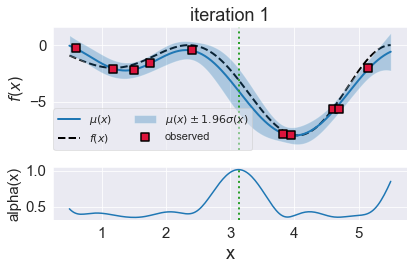

In [53]:
# プロット (GPモデル)
i = 0
pdf = PdfPages("uncertainty_sampling.pdf")
fig = plt.figure()
gs = plt.GridSpec(3, 1)
ax = [fig.add_subplot(gs[0:2, 0]), fig.add_subplot(gs[2, 0])]
ax[0].plot(test_X.flatten(), post_mean, label=r"$\mu(x)$", zorder=2, lw=2)
ax[0].fill_between(
    test_X.flatten(),
    post_mean - post_ci,
    post_mean + post_ci,
    label=r"$\mu(x) \pm 1.96\sigma(x)$",
    alpha=0.3,
    zorder=2,
)
ax[0].plot(
    test_X.flatten(), f_true.flatten(), c="black", ls="--", label=r"$f(x)$", zorder=1, lw=2
)
ax[0].scatter(
    np.array(obs_x),
    np.array(obs_y),
    marker="s",
    s=50,
    color="crimson",
    edgecolor="black",
    lw=1.5,
    zorder=3,
    label="observed",
)
    
ax[0].tick_params(labelbottom=False)
ax[0].set_ylabel(r"$f(x)$")
ax[0].legend(borderaxespad=0, ncol=2, framealpha=0.5, fontsize=11)
ax[0].set_title("iteration {}".format(i + 1))

# 獲得関数を最大にする点を選ぶ
next_i = np.argmax(post_std) # uncertainty sampling

ax[1].plot(x, post_std)
ax[0].axvline(x[next_i], ls=":", c="tab:green", lw=2)
ax[1].axvline(x[next_i], ls=":", c="tab:green", lw=2)
ax[1].set_xlabel("x", fontsize=18)
ax[1].set_ylabel(r"alpha(x)")

fig.tight_layout()
pdf.savefig(fig)